In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import keras 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
 
tf.__version__

'2.4.1'

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [3]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



from google.colab import drive
drive.mount('/content/gdrive')


In [5]:
# Part 1 - Data Preprocessing

# Preprocessing the Training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Data/train',
                                                 target_size = (224,224),
                                                 batch_size = 64,
                                                 shuffle = True,
                                                 class_mode = 'categorical')

# Preprocessing the Test set
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Data/test',
                                            target_size = (224, 224)
                                            )

Found 6344 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [6]:
# Part 2 - Building the CNN
input_tensor = Input(shape=(224, 224, 3))
vgg_weights = "/content/drive/MyDrive/Colab Notebooks/vgg19_weights_tf_dim_ordering_tf_kernels_notop (1).h5"
base_model = tf.keras.applications.VGG19(
    input_tensor=input_tensor,
    include_top  = False,
    weights      = None,
)
base_model.load_weights(vgg_weights)
x = base_model.output
print(base_model.input)
print(base_model.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")


In [7]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
#base_model.trainable = False
x = tf.keras.layers.GlobalAveragePooling2D()
#x = Dense(1024, activation='relu')(x)
predictions = tf.keras.layers.Dense(3,activation="softmax")

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential([base_model,
                   x,
                    predictions
                ])
print(model)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 1539      
Total params: 20,025,923
Trainable params: 20,025,923
Non-trainable params: 0
_________________________________________________________________


In [9]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
#base_model.trainable = False
for layer in base_model.layers:
    layer.trainable = False

In [11]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

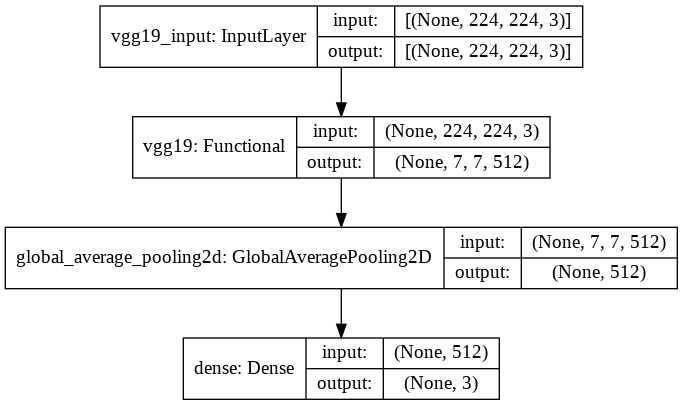

In [12]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_layer_names =True,show_shapes = True)

In [13]:
def get_callbacks(name):
    return[
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_categorical_crossentropy',patience=1),
    ]

In [14]:
base_learning_rate  = 0
model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy",metrics=[tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy'),'accuracy'])

In [15]:
base_learning_rate  = 0
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])

In [23]:
history = model.fit(x=training_set, validation_data = test_set,steps_per_epoch=100,epochs=50)

Epoch 1/50
100/100 [==============================] - 1173s 12s/step - loss: 0.3718 - accuracy: 0.8673 - val_loss: 0.3105 - val_accuracy: 0.8929
Epoch 2/50
100/100 [==============================] - 206s 2s/step - loss: 0.3237 - accuracy: 0.8841 - val_loss: 0.2849 - val_accuracy: 0.8913
Epoch 3/50
100/100 [==============================] - 207s 2s/step - loss: 0.2929 - accuracy: 0.8988 - val_loss: 0.2754 - val_accuracy: 0.9014
Epoch 4/50
100/100 [==============================] - 207s 2s/step - loss: 0.2635 - accuracy: 0.9065 - val_loss: 0.2496 - val_accuracy: 0.9154
Epoch 5/50
100/100 [==============================] - 207s 2s/step - loss: 0.2522 - accuracy: 0.9113 - val_loss: 0.2520 - val_accuracy: 0.9045
Epoch 6/50
100/100 [==============================] - 207s 2s/step - loss: 0.2396 - accuracy: 0.9163 - val_loss: 0.2271 - val_accuracy: 0.9293
Epoch 7/50
100/100 [==============================] - 207s 2s/step - loss: 0.2292 - accuracy: 0.9195 - val_loss: 0.2182 - val_accuracy: 0.92

In [17]:
classes =["COVID-19","NORMAL","PNEUMONIA"]

In [18]:
model.evaluate(test_set)

41/41 [==============================] - 28s 693ms/step - loss: 0.3715 - accuracy: 0.8634


[0.3714902698993683, 0.8633540272712708]

In [19]:
print(training_set.class_indices)

{'COVID19': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


Text(0.5, 1.0, 'Training and Test loss')

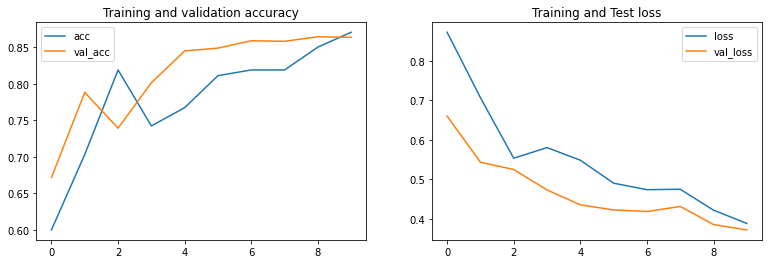

In [20]:
import matplotlib.pyplot as plt
# Accuracy/validation plots
h = history.history
fig = plt.figure(figsize = (13, 4))

plt.subplot(121)
plt.plot(h['accuracy'], label = 'acc')
plt.plot(h['val_accuracy'], label = 'val_acc')
plt.legend()
plt.grid(False)
plt.title(f'Training and validation accuracy')

plt.subplot(122)
plt.plot(h['loss'], label = 'loss')
plt.plot(h['val_loss'], label = 'val_loss')
plt.legend()
plt.grid(False)
plt.title(f'Training and Test loss')

In [30]:
prediction = base_model.predict_generator(test_set)
prediction=np.array(prediction)
prediction =(np.round(prediction))
prediction=prediction.astype(int)
prediction = prediction.reshape(1, -1)[0]
print(prediction[0:15:0])
print(test_set.classes[0:15:0])
cm = confusion_matrix(test_set.classes[0:48:0,],prediction[0:48:0,])
ax= plt.subplot()
ay= plt.subplot()
az= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['COVID19', 'NORMAL', 'PNEUMONIA']); ax.yaxis.set_ticklabels(['COVID19', 'NORMAL', 'PNEUMONIA']);


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


ValueError: ignored

In [22]:
Y_pred = model_vgg.predict_generator(testing_set)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(testing_set.classes, y_pred))
print('Classification Report')
target_names = ['Covid', 'Normal', 'Pneumonia']
print(classification_report(testing_set.classes, y_pred, target_names=target_names))

NameError: ignored